## Latent Integration Network (LIN)
This notebook gives an example of how to train a LIN on SVD vectors. Note: 05_experiment_SVD.ipynb created and saved the SVD Decomposition. 

## Imports

In [1]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.pnnlDatasets import CCSI_2D

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, convertSimToImage, pkl_save, pkl_load, \
                                    create_1_channel_movie

from surrogates4sims.models import Generator, Encoder, ConvDeconvFactor2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from glob import glob

In [2]:
!ls /work/pnnl_liquid_inlet/channel_1

gridsize_128  gridsize_512  svd_channel1_gridsize128.pkl


## Settings

In [3]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "LIN_SVD_PNNL"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "2"#,1,2,3"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
channel = 2
gridsize = 128
dataDirec = '/work/pnnl_liquid_inlet/channel_{}/gridsize_{}'.format(channel,gridsize)
build_vecs = True 
SVDFn = '/work/pnnl_liquid_inlet/channel_{}/svd_channel{}_gridsize{}.pkl'.format(channel,channel,gridsize)
preprocess = False
AE = True

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  
patience = 1

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .2
bz = 1
numSamplesToKeep = np.infty #if not debugging
latentDim = 64
simLen = 500

w = 499
memory_length = 6
hiddenLayers =  [128, 128, 128]
hd ='_'.join(map(str,hiddenLayers))
activation = nn.ELU()

if DEBUG:
    epochs = 2
    numSamplesToKeep = 200
    createDebugData = True
    

versionName = versionName + '_w{}_latentDim{}_hd{}_bz{}_epochs{}_memory{}'.format(w,latentDim,hd,bz,epochs,
                                                                                 memory_length)
versionName

'LIN_SVD_PNNL_GPUs2_w499_latentDim64_hd128_128_128_bz1_epochs1000_memory6'

## Select Personal GPUs

In [4]:
!nvidia-smi

Sat Jan 23 20:43:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |     12MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |     12MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [7]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [8]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Sat Jan 23 20:43:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |     12MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   18C    P8     8W / 250W |     12MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Build Latent Vectors (Warning....)
The computation of building the latent vectors takes a loooong time. 
This codes checks to see if svd_vec_file has been saved. If it has, 
it will reload them. 

In [9]:
sims = glob(os.path.join(dataDirec,'*.pkl'))
sims = sorted(sims)
numSims = len(sims)
idx = int(testSplit*numSims)
testInds = np.linspace(1,numSims-2,idx).astype('int')
trainInds = list(set(np.arange(0,numSims)).difference(set(testInds)))
# perm = np.random.permutation(numSims)
# testInds = perm[:idx]
# trainInds = perm[idx:]
testSimFiles = [sims[idx] for idx in testInds]
trainSimFiles = [sims[idx] for idx in trainInds]
len(testSimFiles), len(trainSimFiles)

(10, 40)

In [10]:
trainSimFiles = [trainSimFiles[0]]

testSimFiles = trainSimFiles

In [11]:
class CCSI_2D_one_of_each_getitem(Dataset):
    def __init__(self, 
                 dataFiles,
                 txtFile = '/data/ccsi/pnnl_liquid_inlet/liquid_inlet_velocity.txt',
                 channel=1,
                 gridSize=128,
                 simLen = 500,
                 w = 10, # this is the length of the Y output to predict
                 AE = False, # this only return x,x, i.e. no y.
                 numToKeep=np.infty,doPreprocess=False): 
        
        self.dataFiles = dataFiles
        if numToKeep < len(self.dataFiles):
            self.dataFiles = self.dataFiles[:numToKeep]

        self.channel = channel
        self.gridSize = gridSize
        self.numToKeep = numToKeep
        self.simLen = simLen
        self.t = np.linspace(0,1,simLen).astype('float32')
        self.w = w
        self.AE = AE
        self.doPreprocess = doPreprocess
        
        # Get the inlet velocity
        with open(txtFile) as fid:
            txt = fid.read().splitlines()
        inletVelocity = np.array(list(map(float,txt[1:]))).astype('float32')
        self.inletMx = np.max(inletVelocity)
        self.inletMn = np.min(inletVelocity)
        
        data = []
        for fn in self.dataFiles:
            idx = int(fn.split('/')[-1].replace('.pkl','')) - 1
            D = pkl_load(fn)
            data.append((D,inletVelocity[idx]))
               
        self.data = data
    
    def __len__(self):
        return len(self.simLen*self.data)


    def __getitem__(self, idx):
        q,r = np.divmod(idx,self.simLen)
        r_idx = r
            
        X,p = self.data[q]
        x = X[r_idx:r_idx+1]
        #print(x.shape)
        y = X[r_idx+1:r_idx+self.w+1]
        #print(y.shape)
        if self.doPreprocess:
            x = self.preprocessFcn(x)
            y = self.preprocessFcn(y)
        
        y = np.expand_dims(y,1)
        p_x = np.hstack([p,self.t[r_idx]])
        p_y = np.vstack([p*np.ones((self.w,)),self.t[r_idx+1:r_idx+self.w+1]]).T
        X = x.astype('float32')
        Y = y.astype('float32')
        if self.AE:
            return X,X # this allows LR_finder to work
        else:
            return X, Y, p_x, p_y

In [12]:
testDataset = CCSI_2D_one_of_each_getitem(testSimFiles,doPreprocess=preprocess,
                                          numToKeep=numSamplesToKeep,channel=channel,w=0,AE=False)
trainDataset = CCSI_2D_one_of_each_getitem(trainSimFiles,doPreprocess=preprocess,
                                           numToKeep=numSamplesToKeep,channel=channel,w=0,AE=False)
len(trainDataset),len(testDataset)

(500, 500)

In [13]:
# this is monotonic now because we set sims=sorted(sims)
[i for x,i in trainDataset.data]

[0.002]

In [14]:
svd_data = pkl_load(SVDFn)
print(svd_data.keys())

svd_vecs = svd_data['spatialVecs'][:,:latentDim]
print(svd_vecs.shape)

dict_keys(['spatialVecs', 'S', 'timeVecs_transpose'])
(16384, 64)


In [15]:
class SVD_Encoder(nn.Module):
    def __init__(self, U):
        super(SVD_Encoder,self).__init__()
        self.U = U

    def forward(self, frames):
        # u is from u,s,vh = svd(data)
        # frames = batch_size x channels x height x width
        assert len(frames.shape)==4
        x = frames.reshape(len(frames), -1)
        coeffs = x.matmul(self.U)
        # coeffs is now batch_size x numComp
        return coeffs    
    
class SVD_Decoder(nn.Module):
    def __init__(self, U):
        super(SVD_Decoder,self).__init__()
        self.U = U

    def forward(self, coeffs, orig_shape):
        # coeffs is now batch_size x numComp
        R = self.U.matmul(coeffs.T)
        R = R.T.reshape(orig_shape)
        return R
    
class SVD_Autoencoder(nn.Module):

    def __init__(self, svd_vectors, latentDim, allow_updates_to_U):
        super(SVD_Autoencoder,self).__init__()
        self.U = nn.Parameter(torch.tensor(svd_vectors[:,:latentDim]), requires_grad = allow_updates_to_U)
        self.encoder=SVD_Encoder(self.U)
        self.decoder=SVD_Decoder(self.U)
        
    def forward(self, frames):
        return self.decoder(self.encoder(frames))

SVD_autoencoder = SVD_Autoencoder(svd_vecs, latentDim, False).to(device)

In [16]:
def createSVDdataset(Dataset, latentDim):

    # datasets may be smaller because: numSamplesToKeep 
    # Be careful the default is for the data to be preprocessed. Therefore, we have to invPrecprocess if 
    # we are looking at relative errors. 
    loader = DataLoader(dataset=Dataset, batch_size=simLen, shuffle=False, num_workers=4)
    X, Y, p_x, p_y = next(iter(loader))
    print(X.shape, Y.shape, p_x.shape, p_y.shape)
    z = []
    p = []
    for batch in loader:
        X, Y, p_x, p_y = batch
        z.append(SVD_autoencoder.encoder(X.to(device)).cpu())
        p.append(p_x.cpu())
        
    z = torch.stack(z).reshape(-1, latentDim)
    p = torch.stack(p).reshape(-1, p_x.size(1))
    

    v = np.arange(0, len(z), simLen)

    sims = []
    for idx in v:
        sims.append((z[idx:idx+simLen],p[idx:idx+simLen]))
    print('num_sims {}'.format(len(sims)))
    return sims

train_data = createSVDdataset(trainDataset, latentDim)
test_data = createSVDdataset(testDataset, latentDim)

torch.Size([500, 1, 128, 128]) torch.Size([500, 0, 1, 128, 128]) torch.Size([500, 2]) torch.Size([500, 0, 2])
num_sims 1
torch.Size([500, 1, 128, 128]) torch.Size([500, 0, 1, 128, 128]) torch.Size([500, 2]) torch.Size([500, 0, 2])
num_sims 1


In [17]:
train_data[0][0].shape, train_data[0][1].shape

(torch.Size([500, 64]), torch.Size([500, 2]))

In [18]:
# reduce the dimensions of z down to the latentDim 
for idx,d in enumerate(train_data):
    X = d[0][:,:latentDim]
    p = d[1]
    train_data[idx] = (X,p)
    
for idx,d in enumerate(test_data):
    X = d[0][:,:latentDim]
    p = d[1]
    test_data[idx] = (X,p)

In [19]:
print(train_data[0][1])

tensor([[0.0020, 0.0000],
        [0.0020, 0.0020],
        [0.0020, 0.0040],
        [0.0020, 0.0060],
        [0.0020, 0.0080],
        [0.0020, 0.0100],
        [0.0020, 0.0120],
        [0.0020, 0.0140],
        [0.0020, 0.0160],
        [0.0020, 0.0180],
        [0.0020, 0.0200],
        [0.0020, 0.0220],
        [0.0020, 0.0240],
        [0.0020, 0.0261],
        [0.0020, 0.0281],
        [0.0020, 0.0301],
        [0.0020, 0.0321],
        [0.0020, 0.0341],
        [0.0020, 0.0361],
        [0.0020, 0.0381],
        [0.0020, 0.0401],
        [0.0020, 0.0421],
        [0.0020, 0.0441],
        [0.0020, 0.0461],
        [0.0020, 0.0481],
        [0.0020, 0.0501],
        [0.0020, 0.0521],
        [0.0020, 0.0541],
        [0.0020, 0.0561],
        [0.0020, 0.0581],
        [0.0020, 0.0601],
        [0.0020, 0.0621],
        [0.0020, 0.0641],
        [0.0020, 0.0661],
        [0.0020, 0.0681],
        [0.0020, 0.0701],
        [0.0020, 0.0721],
        [0.0020, 0.0741],
        [0.0

In [20]:
print(test_data[-1][1])

tensor([[0.0020, 0.0000],
        [0.0020, 0.0020],
        [0.0020, 0.0040],
        [0.0020, 0.0060],
        [0.0020, 0.0080],
        [0.0020, 0.0100],
        [0.0020, 0.0120],
        [0.0020, 0.0140],
        [0.0020, 0.0160],
        [0.0020, 0.0180],
        [0.0020, 0.0200],
        [0.0020, 0.0220],
        [0.0020, 0.0240],
        [0.0020, 0.0261],
        [0.0020, 0.0281],
        [0.0020, 0.0301],
        [0.0020, 0.0321],
        [0.0020, 0.0341],
        [0.0020, 0.0361],
        [0.0020, 0.0381],
        [0.0020, 0.0401],
        [0.0020, 0.0421],
        [0.0020, 0.0441],
        [0.0020, 0.0461],
        [0.0020, 0.0481],
        [0.0020, 0.0501],
        [0.0020, 0.0521],
        [0.0020, 0.0541],
        [0.0020, 0.0561],
        [0.0020, 0.0581],
        [0.0020, 0.0601],
        [0.0020, 0.0621],
        [0.0020, 0.0641],
        [0.0020, 0.0661],
        [0.0020, 0.0681],
        [0.0020, 0.0701],
        [0.0020, 0.0721],
        [0.0020, 0.0741],
        [0.0

## Investigate how to preprocess the data

In [21]:
len(train_data), len(test_data)

(1, 1)

In [22]:
D = []
for d in train_data:
    D.append(np.hstack(d))
D = np.vstack(D)
D.shape

(500, 66)

In [23]:
D.min()

-22.716675

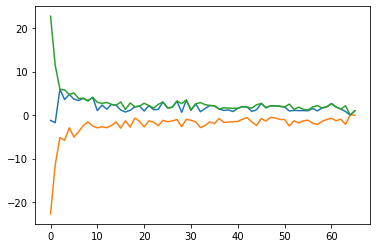

In [24]:
x_mx = np.max(D,axis=0)
x_mn = np.min(D,axis=0)
abs_x_mx = np.max(abs(D),axis=0)
plt.plot(x_mx)
plt.plot(x_mn)
plt.plot(abs_x_mx)
plt.show()

## Dataset and Dataloader

In [25]:
class LatentVectors(Dataset):
    def __init__(self, data,doPreprocess=False,w=1,simLen=200,abs_x_mx=abs_x_mx, memory=6):
        self.data = data
        self.doPreprocess = doPreprocess
        self.simLen = simLen
        self.w = w
        self.abs_x_mx = abs_x_mx[:-2]
        self.abs_p_mx = abs_x_mx[-2:]
        self.memory= memory
                 
    def __len__(self):
        return self.simLen*len(self.data)

    def preprocess_x(self,x):
        if x.shape[0] == self.abs_x_mx.shape[0]:
            return x/self.abs_x_mx[:,None]
        else:
            return x/self.abs_x_mx

    def preprocess_p(self,p):
        if p.shape[0] == self.abs_p_mx.shape[0]:
            return p/self.abs_p_mx[:,None]
        else:
            return p/self.abs_p_mx

    def invPreprocess_x(self,xnew):
        x = xnew*self.abs_x_mx
        return x

    def invPreprocess_p(self,pnew):
        p = pnew*self.abs_p_mx
        return p
    
    def __getitem__(self, idx):
        q,r = np.divmod(idx,self.simLen)
        X, p = self.data[q]
        r_idx = np.random.randint(0,self.simLen-self.w)
        
        x = torch.zeros((latentDim, self.memory))
        p_x = torch.zeros((2, self.memory))
        
        x[:,0] = X[r_idx:r_idx+1]
        y = X[r_idx+1:r_idx+self.w+1]
        
        p_x[:,0] = p[r_idx:r_idx+1]
        p_y = p[r_idx+1:r_idx+self.w+1]
        
        if self.doPreprocess:
            x = self.preprocess_x(x)
            y = self.preprocess_x(y)
            p_x = self.preprocess_p(p_x)
            p_y = self.preprocess_p(p_y)
        
        return x, y, p_x, p_y

In [26]:
trainDataset = LatentVectors(train_data,doPreprocess=True,w=w,simLen=simLen,abs_x_mx=abs_x_mx,
                             memory=memory_length)
testDataset = LatentVectors(test_data,doPreprocess=True,w=w,simLen=simLen,abs_x_mx=abs_x_mx,memory=memory_length)
X,y,p_x,p_y = trainDataset[0]
X.shape,y.shape,p_x.shape,p_y.shape

(torch.Size([64, 6]),
 torch.Size([499, 64]),
 torch.Size([2, 6]),
 torch.Size([499, 2]))

In [27]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)
len(trainDataset), len(trainDataLoader), len(testDataset), len(testDataLoader)

(500, 500, 500, 500)

In [28]:
X,y, p_x, p_y = next(iter(trainDataLoader))
X.shape, y.shape, p_x.shape, p_y.shape

(torch.Size([1, 64, 6]),
 torch.Size([1, 499, 64]),
 torch.Size([1, 2, 6]),
 torch.Size([1, 499, 2]))

In [29]:
p_x

tensor([[[1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]])

## Model

In [30]:
class Autoregressive_Conv_Net(nn.Module):
    def __init__(self, X, hiddenLayerSizes = [128, 128, 128], activation=nn.ELU(), memory = 6):
        super(Autoregressive_Conv_Net,self).__init__()
        
        self.memory = memory
        self.activation = activation
        if hiddenLayerSizes[-1] != 64:
            hiddenLayerSizes.append(64)
        self.modules = []
        for idx,sz in enumerate(hiddenLayerSizes):
            if idx == 0:
                in_channels = latentDim
            else:
                in_channels = hiddenLayerSizes[idx-1]
            # flip the channel_in-length order?
            self.modules.append(nn.Conv1d(in_channels, hiddenLayerSizes[idx], 3, padding=1)) 
            self.modules.append(self.activation)
            
        self.layers = nn.Sequential(*self.modules)

        self.output = nn.Conv1d(memory, 1, 1, padding=0)
        
        #self.output = nn.Linear(hiddenLayerSizes[-1]*memory, latentDim)
                                
        
    def forward(self,x):
        x = self.layers(x)
        if type(self.output) == nn.Conv1d:
            x = self.output(x.transpose(-1,-2)).squeeze()
        else:
            x = self.output(x.view(x.size(0), -1))
        return x

In [31]:
model = Autoregressive_Conv_Net(X, hiddenLayerSizes=hiddenLayers,activation=activation,memory=memory_length)
model

Autoregressive_Conv_Net(
  (activation): ELU(alpha=1.0)
  (layers): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ELU(alpha=1.0)
    (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ELU(alpha=1.0)
    (4): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): ELU(alpha=1.0)
    (6): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ELU(alpha=1.0)
  )
  (output): Conv1d(6, 1, kernel_size=(1,), stride=(1,))
)

In [32]:
output = model(X.float())
output.shape

torch.Size([64])

In [33]:
if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

In [34]:
printNumModelParams(model)

10 layers require gradients (unfrozen) out of 10 layers
147,911 parameters require gradients (unfrozen) out of 147,911 parameters


In [35]:
del SVD_autoencoder
torch.cuda.empty_cache()

In [36]:
SVD_autoencoder = SVD_Autoencoder(svd_vecs, latentDim, False)

In [37]:
# surrogate class

class Surrogate(nn.Module):
    
    def __init__(self, window,
                 z_size, p_size,
                LIN, encoder, decoder):
        super(Surrogate, self).__init__()
        self.window = window
        self.z_size = z_size # this does not include the size of p
        self.p_size = p_size
        self.c_size = z_size + p_size # this does include the size of p
        self.LIN = LIN
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, U):
        
        self.shape_of_last_frames_encoded = U.shape
        
        return self.encoder(U)
        
    def decode(self, encoding):
        
        self.shape_of_last_frames_encoded = torch.Size([encoding.size(0), 1, 128, 128])
        
        return self.decoder(encoding, self.shape_of_last_frames_encoded)
        
    def predict_next_w_encodings(self, encoding, p_y, window):
        '''
        use the LIN to predict the next w encodings for each 
        encoded U in the batch
        '''
            
        predicted_encodings = []
            
        # given a batch of encodings, advance each encoding window time steps.
        # save the result at each time step
        for i in range(window):
            memory_to_save = encoding[:,:,0:-1].clone()
            encoding[:,:,0] = self.LIN(encoding.clone()) + encoding[:,:,0] # use LIN to predict delta in encoding
            encoding[:,:,1:] = memory_to_save
            encoding[:,-self.p_size:,0] = p_y[:, i]
                    
            predicted_encodings.append(encoding[:,:,0].clone())
            
            
        return torch.stack(predicted_encodings)
    
    def forward(self, U, p_x, p_y, window = None):
        
        if window == None:
            window = self.window
        assert p_y.size(1) == window
            
        #encoding = self.encode(U)
        encoding = U
        encoding[:,-self.p_size:] = p_x
        encoding_w = self.predict_next_w_encodings(encoding, p_y, window)
        # want to have this agree with U_y, which is [batch_size, window_size, channels, nx, ny]
        # right now, it's [window_size, batch_size, c_size], so transpose dimensions 0 and 1
        # print(encoding_w.shape)
        U = torch.stack([self.decode(encoding_i) for encoding_i in encoding_w])
        
        return U.transpose(0,1), encoding_w.transpose(0,1)
    
    
surrogate = Surrogate(w, latentDim - 2, 2, model, SVD_autoencoder.encoder, 
                      SVD_autoencoder.decoder)

In [38]:
model.output.weight.device

device(type='cpu')

In [39]:
U, encoding_hat = surrogate(X.float(), p_x.float(), p_y.float())
U.shape, encoding_hat.shape

(torch.Size([1, 499, 1, 128, 128]), torch.Size([1, 499, 64]))

In [40]:
np.allclose(encoding_hat[:,:,-2:].detach().cpu(), p_y)

True

In [41]:
surrogate = Surrogate(w, latentDim - 2, 2, model, SVD_autoencoder.encoder, 
                      SVD_autoencoder.decoder).to(device)
if len(gpu_ids.split(',')) > 1:
    surrogate = nn.DataParallel(surrogate)

## Loss Function

In [42]:
def L2_relative_loss(pred, target):
    return torch.norm(pred - target)/torch.norm(target)


def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(jacobian(pred, device), jacobian(target, device))


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


def MSE(pred,target):
    return nn.MSELoss()(pred, target)


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
        
    L = MSE(pred, target)
        
    return L 

In [43]:
y[:,:,-2:] = p_y
y.shape, p_y.shape

(torch.Size([1, 499, 64]), torch.Size([1, 499, 2]))

In [44]:
loss(encoding_hat, y, device)

tensor(5413.9062, grad_fn=<MseLossBackward>)

## Set LR

In [45]:
'''
doesn't work with our dataloader
if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
    opt = create_opt(1e-7,model)
    find_lr(model,opt,L,device,trainDataLoader)
'''

"\ndoesn't work with our dataloader\nif findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???\n    opt = create_opt(1e-7,model)\n    find_lr(model,opt,L,device,trainDataLoader)\n"

In [46]:
max_lr = .001
opt = torch.optim.Adam(model.parameters(),lr=max_lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

In [47]:
versionName = versionName + '_lr{}'.format(str(max_lr))

In [48]:
versionName = versionName + '_1sim'

In [49]:
versionName

'LIN_SVD_PNNL_GPUs2_w499_latentDim64_hd128_128_128_bz1_epochs1000_memory6_lr0.001_1sim'

## Train

In [67]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        Encoding_x, Encoding_y, p_x, p_y = sampleBatch
        Encoding_x = Encoding_x.to(device)
        p_x = p_x.to(device)
        Encoding_y = Encoding_y.to(device)
        p_y = p_y.to(device)
            

        # zero the parameter gradients
        opt.zero_grad()

        U_hat, encoding_hat = model(Encoding_x, p_x, p_y)
        pl = 0
        with torch.no_grad():
            Encoding_y[:,:,-2:] = p_y 
        ll = loss(encoding_hat, Encoding_y, device)
        combined_loss = pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss
        
        batch_ploss = pl
        running_ploss += batch_ploss



        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)
        #lr_scheduler.step()

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            running_ploss = 0.0
            tensorboard_writer.flush()

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps

In [68]:
def validEpoch(myDataLoader, tensorboard_writer, model, p_loss, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        Encoding_x, Encoding_y, p_x, p_y = sampleBatch
        Encoding_x = Encoding_x.to(device)
        p_x = p_x.to(device)
        Encoding_y = Encoding_y.to(device)
        p_y = p_y.to(device)
                
        perc = len(Encoding_x)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            U_hat, encoding_hat = model(Encoding_x, p_x, p_y)
            
        Encoding_y[:,:,-2:] = p_y 

        # loss
        combined_loss = loss(encoding_hat, Encoding_y, device)
        
        running_loss += perc*(combined_loss.item())


    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.flush()
    
    return running_loss

In [69]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")
    
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

checkpoints directory already exists :)


In [ ]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty
torch.autograd.set_detect_anomaly(True)
for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times

    writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)

    surrogate.train()
    trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                   train_writer, surrogate,
                                                                   opt, p_loss, loss,
                                                                   rmse, lr_scheduler, 
                                                                   tensorboard_rate, device,
                                                                   tensorboard_recorder_step, total_steps)

    writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
    writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#         if trainLoss < bestLoss:
#             bestLoss = trainLoss
#             writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#             torch.save(surrogate.state_dict(), os.path.join(cps,versionName))

    surrogate.eval()
    valLoss = validEpoch(testDataLoader, test_writer, surrogate, p_loss, loss, rmse, device, tensorboard_recorder_step)
    writeMessage("valLoss: {:.4e}".format(valLoss),versionName)

    # checkpoint progress
    if valLoss < bestLoss:
        bestLoss = valLoss
        writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
        torch.save(surrogate.state_dict(), os.path.join(cps,versionName))

    lr_scheduler.step(valLoss)

    if opt.param_groups[0]['lr'] < 5e-8:
        break
writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---


In [50]:
# note that I incorrectly said in the version name that latentDim was 1024
surrogate.load_state_dict(torch.load(os.path.join(cps,'LIN_SVD_PNNL_GPUs2_w499_latentDim1024_hd128_128_128_bz1_epochs1000_memory6_lr0.001_1sim')))

<All keys matched successfully>

In [51]:
testDataset_fullSim = LatentVectors(test_data,doPreprocess=True,w=simLen-1,
                            simLen=simLen,abs_x_mx=abs_x_mx,memory=memory_length)
first_frame_testDataset = torch.utils.data.Subset(testDataset_fullSim, range(0, len(testDataset), simLen))
simulation_testDataLoader = DataLoader(dataset=first_frame_testDataset, batch_size=10)

In [52]:
SVD_autoencoder_for_recon_without_physics_vars = SVD_Autoencoder(svd_vecs, latentDim-2, False).to(device)

In [53]:
surrogate.eval()
U_hats = []
Us = []
for i, sampleBatch in enumerate(simulation_testDataLoader, start=1):

    # gpu
    Encoding_x, Encoding_y, p_x, p_y = sampleBatch
    Encoding_x = Encoding_x.to(device)
    p_x = p_x.to(device)
    Encoding_y = Encoding_y.to(device)
    p_y = p_y.to(device)
    with torch.no_grad():
        Encoding_y = testDataset_fullSim.invPreprocess_x(Encoding_y.clone().cpu()).to(device)
        Us.append([SVD_autoencoder_for_recon_without_physics_vars.decoder(e,
                       torch.Size((1,1,128,128))).detach().cpu() for e in Encoding_y[:,:,:-2].transpose(0,1)])
        
        
        U_hat, encoding_hat = surrogate(Encoding_x, p_x, p_y, window=simLen-1)
        encoding_hat = testDataset_fullSim.invPreprocess_x(encoding_hat.clone().cpu()).to(device)
        
        U_hat = [SVD_autoencoder_for_recon_without_physics_vars.decoder(e,
                    torch.Size((1,1,128,128))).detach().cpu() for e in encoding_hat[:,:,:-2].transpose(0,1)]
                    
        U_hats.append(U_hat)
        
        
Real_U = torch.stack(*Us).transpose(0,1)
#Real_X_img = convertSimToImage(Real_X)

Surr_U = torch.stack(*U_hats).transpose(0,1)
#Surr_X_img = convertSimToImage(Surr_X)

In [54]:
sim = -1
rel_error_by_sim_and_frame = []
for batch_real, batch_surr in zip(Real_U,Surr_U):
    sim+=1
    rel_error_by_sim_and_frame.append([])
    for frame_real, frame_surr in zip(batch_real, batch_surr):
        assert frame_real.size()==torch.Size((1,128,128))
        rel_error_by_sim_and_frame[sim].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))
print(sim)

0


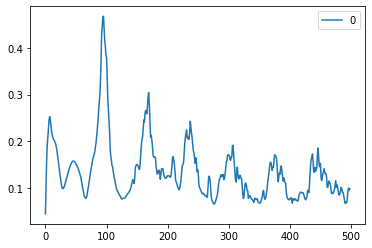

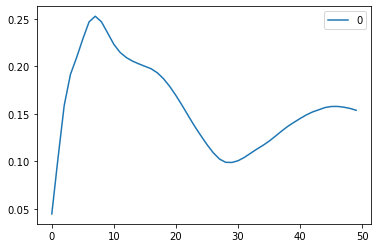

In [55]:
plt.plot(np.vstack(rel_error_by_sim_and_frame).T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
plt.plot(np.vstack(rel_error_by_sim_and_frame)[:,:50].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()

In [ ]:
import matplotlib.animation as animation
def create_1_channel_movie(im,outfile='sim.mp4',title='surrogate            simulation'):
    ti = 0
    u_mx = 255 #np.max(np.abs(Xrgb))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    cmap = plt.cm.ocean
    img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
    #plt.show()
    
    # initialization function: plot the background of each frame
    def init():
        img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)

    # animation function. This is called sequentially
    def animate(i):
        img = ax.imshow(im[i].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        return (fig,)


    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(im), interval=20, blit=True)
    anim.save(outfile, fps=30, extra_args=['-vcodec', 'libx264'])

In [56]:
Real_U_img = [torch.rot90(convertSimToImage(r),1,dims=[2,3]) for row in [Real_U] for r in row]
Surr_U_img = [torch.rot90(convertSimToImage(s),1,dims=[2,3]) for row in [Surr_U] for s in row]

Xrgb = torch.cat([torch.stack(Surr_U_img), torch.stack(Real_U_img)], dim=4)
Xrgb.shape

torch.Size([1, 499, 1, 128, 256])

In [ ]:
try:
    gif = True
    outGif = '{}.gif'.format(versionName)
    create_1_channel_movie(Xrgb[0].detach().numpy(),outfile=outGif)
except:
    gif = False
    outGif = '{}.mp4'.format(versionName)
    create_1_channel_movie(Xrgb[0].detach().numpy(),outfile=outGif)

In [82]:
from IPython.display import Video
Video(outGif)

In [113]:
import matplotlib.animation as animation
def create_1_channel_movie(im, outfile):
    ti = 0
    u_mx = 255 #np.max(np.abs(Xrgb))
    fig = plt.figure()
    #plt.axis('off')
    ax = fig.add_subplot(111)
    cmap = plt.cm.jet
    img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
    #plt.show()
    
    # initialization function: plot the background of each frame
    def init():
        img = ax.imshow(im[0].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        plt.title('Time = 1')
        plt.axis('off')
        return (fig,)

    # animation function. This is called sequentially
    def animate(i):
        print(i)
        img = ax.imshow(im[i].squeeze(), cmap=cmap, vmin=0, vmax=u_mx)
        plt.title('Time = {}'.format(i+1))
        plt.axis('off')
        return (fig,)


    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(im), interval=20, blit=True)
    anim.save(outfile, fps=30, extra_args=['-vcodec', 'libx264'], dpi=300)

In [102]:
#simulation list is created below
actual_img = [torch.rot90(convertSimToImage(s),1,dims=[2,3]) for row in [simulation] for s in row]

mlp_img = pkl_load('08_MLP_surr.pkl')

Xrgb = torch.cat([torch.stack(mlp_img),torch.stack(Real_U_img),torch.stack(Surr_U_img)], dim=4)
Xrgb.shape

torch.Size([1, 499, 1, 128, 384])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

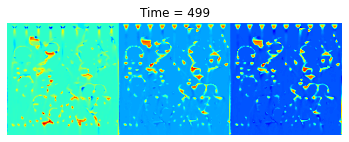

In [114]:
outGif = '{}.mp4'.format('08_1_sim_train_compare')
create_1_channel_movie(Xrgb[0].detach().numpy(),outfile=outGif)

In [100]:

test_img = torch.cat([torch.stack(mlp_img),torch.stack(Real_U_img),torch.stack(Surr_U_img)], dim=4)
test_img=test_img[0].transpose(1,3)
test_img=test_img.transpose(1,2)
test_img.shape
import imageio
imageio.mimwrite('test_vid.mp4', test_img , fps = 60)

### Some error metrics:

In [61]:
first_simulation = CCSI_2D_one_of_each_getitem(trainSimFiles,doPreprocess=preprocess,
                                           numToKeep=numSamplesToKeep,channel=channel,w=0,AE=False)

In [62]:
simulation = torch.stack([torch.tensor(frame[0]) for frame in first_simulation])[1:].unsqueeze(0)
simulation.shape

torch.Size([1, 499, 1, 128, 128])

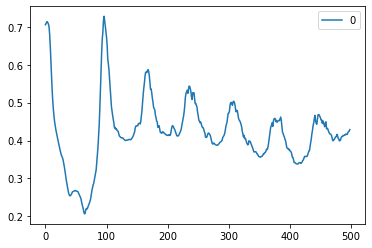

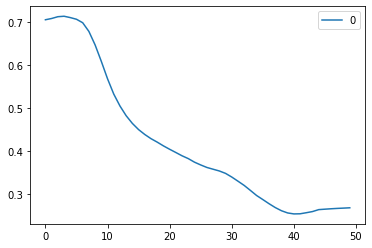

mean relative error was: 0.4220230281352997


In [85]:
sim = -1
rel_error_by_sim_and_frame = []
for batch_real, batch_surr in zip(simulation,Surr_U):
    sim+=1
    rel_error_by_sim_and_frame.append([])
    for frame_real, frame_surr in zip(batch_real, batch_surr):
        assert frame_real.size()==torch.Size((1,128,128))
        rel_error_by_sim_and_frame[sim].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))

# note that this relative error uses the SVD reconstruction as the baseline
plt.plot(np.vstack(rel_error_by_sim_and_frame).T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
plt.plot(np.vstack(rel_error_by_sim_and_frame)[:,:50].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
print('mean relative error was: {}'.format(torch.tensor(rel_error_by_sim_and_frame).mean()))

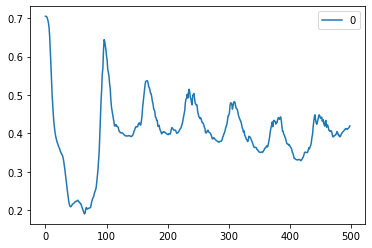

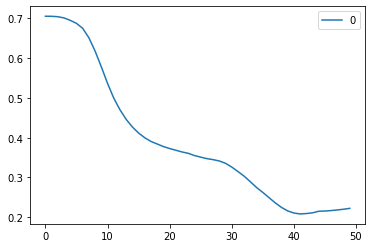

mean relative error was: 0.4010922908782959


In [86]:
sim = -1
rel_error_by_sim_and_frame = []
for batch_real, batch_surr in zip(simulation,Real_U):
    sim+=1
    rel_error_by_sim_and_frame.append([])
    for frame_real, frame_surr in zip(batch_real, batch_surr):
        assert frame_real.size()==torch.Size((1,128,128))
        rel_error_by_sim_and_frame[sim].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))

# note that this relative error uses the SVD reconstruction as the baseline
plt.plot(np.vstack(rel_error_by_sim_and_frame).T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
plt.plot(np.vstack(rel_error_by_sim_and_frame)[:,:50].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
print('mean relative error was: {}'.format(torch.tensor(rel_error_by_sim_and_frame).mean()))

0


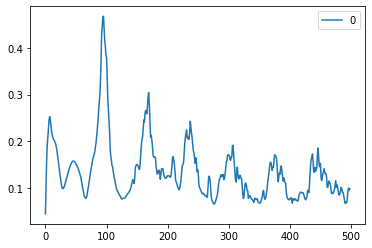

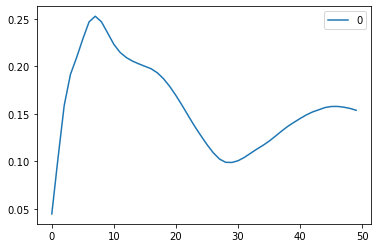

mean relative error was: 0.13639995455741882


In [87]:
sim = -1
rel_error_by_sim_and_frame = []
for batch_real, batch_surr in zip(Real_U,Surr_U):
    sim+=1
    rel_error_by_sim_and_frame.append([])
    for frame_real, frame_surr in zip(batch_real, batch_surr):
        assert frame_real.size()==torch.Size((1,128,128))
        rel_error_by_sim_and_frame[sim].append( torch.norm(frame_surr - frame_real)/torch.norm(frame_real))
print(sim)

# note that this relative error uses the SVD reconstruction as the baseline
plt.plot(np.vstack(rel_error_by_sim_and_frame).T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
plt.plot(np.vstack(rel_error_by_sim_and_frame)[:,:50].T)
plt.legend([i for i in range(len(testSimFiles))])
plt.show()
print('mean relative error was: {}'.format(torch.tensor(rel_error_by_sim_and_frame).mean()))